In [1]:
import qutip
import numpy as np
import pprint
import matplotlib.pyplot as plt

# Hamiltonian Evolution with a Pulse Sequence: A 1D array example

We shall emulate using qutip a series of pulse sequences created with Pulser

In [2]:
try:
    import pulser
except ModuleNotFoundError:
    import sys
    sys.path.insert(1, '../')

from pulser import Pulse, Sequence, Register
from pulser.devices import Chadoq2

In [3]:
# Three-state basis:
r = qutip.Qobj([[1],[0],[0]])
e = qutip.Qobj([[0],[1],[0]])
g = qutip.Qobj([[0],[0],[1]])

In [4]:
# Basic transition operators:
I = qutip.qeye(3)

sigma_gr = qutip.Qobj([[0,0,1],[0,1,0],[1,0,0]])
rydY = qutip.Qobj([[0,0,-1j],[0,1,0],[1j,0,0]])
rydZ = qutip.Qobj([[1,0,0],[0,0,0],[0,0,-1]])

sigma_ge = qutip.Qobj([[1,0,0],[0,0,1],[0,1,0]])
excY = qutip.Qobj([[1,0,0],[0,0,-1j],[0,1j,0]])
excZ = qutip.Qobj([[0,0,0],[0,1,0],[0,0,-1]])

sigma_rr = qutip.Qobj([[1,0,0],[0,0,0],[0,0,0]])
sigma_ee = qutip.Qobj([[0,0,0],[0,1,0],[0,0,0]])
sigma_gg = qutip.Qobj([[0,0,0],[0,0,0],[0,0,1]])

We use a simple 1D chain of atoms

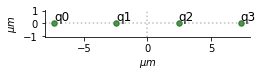

In [76]:
# Atom Register
L = 4
reg1 = Register.rectangle(1, L, spacing=4.9,prefix='q')
reg1.draw()  


In [77]:
#Define Device 
device = Chadoq2(reg1) 

In [78]:
#Define sequence and Set channels
seq = Sequence(device)
seq.declare_channel('local', 'raman_local')
seq.declare_channel('global', 'rydberg_global')

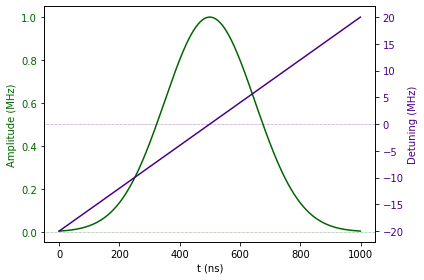

In [79]:
#Create waveforms and pulse
from pulser.waveforms import RampWaveform, GaussianWaveform

duration = 1000
amp_wf = GaussianWaveform(duration, 1, 150)   # Duration: 1000 ns, Max Amp: 1 MHz, Stdev: 150 ns
detuning_wf = RampWaveform(duration, -20, 20)  # Duration: 1000ns, linear sweep from -20 to 20 MHz

complex_pulse = Pulse(amp_wf, detuning_wf, phase=0)
complex_pulse.draw()

In [91]:
seq.target('q0','local')
seq.add(complex_pulse, 'local')
seq.add(complex_pulse, 'global')

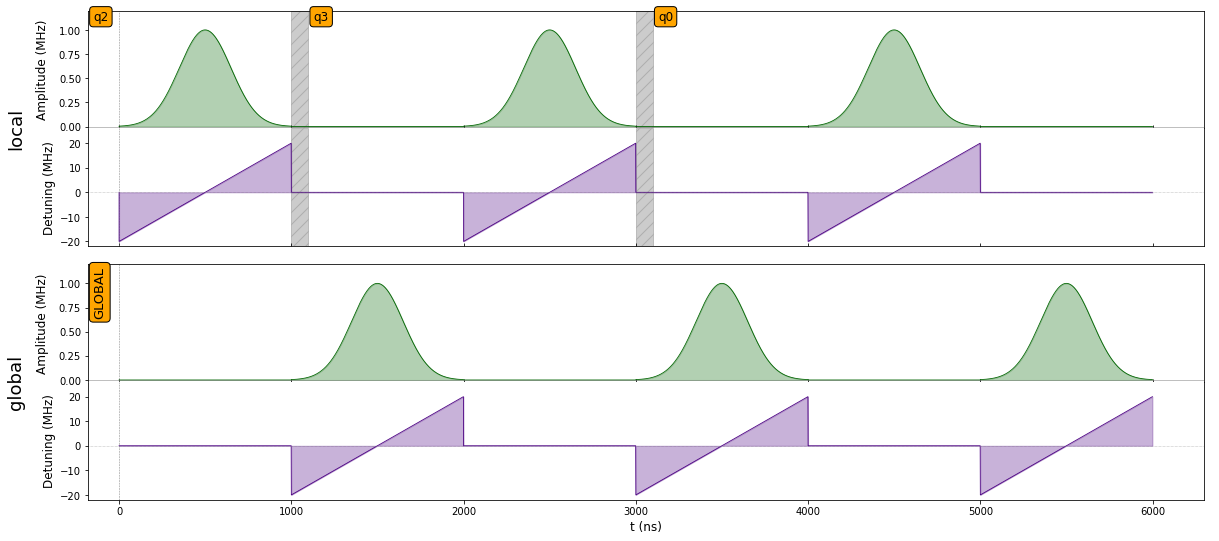

In [92]:
seq.draw()

Now that we have the pulse sequence, we emulate the evolution of the atom array using Qutip

In [93]:
#Define Operators
# Global variable for generating tensor product of identities
ones = [qutip.qeye(3) for _ in range(L)]

def get_neighbors(qubit_id, L):
    """
    returns the labels of the nearest neighbors of a qubit ID, with open boundary conditions
    """
    i = int(qubit_id[1:])
    if i == 0:
        return([f'q1'])
    elif i == L-1:
        return([f'q{L-2}'])
    else:
        return([f'q{i-1}',f'q{i+1}'])

def local_operator(qubit_id,operator):
    """
    Returns a local gate at a qubit
    """
    temp = ones.copy()
    pos = int(qubit_id[1:]) #Runs from 0 to L-1
    temp[pos] = operator
    return qutip.tensor(temp)

def two_body_operator(qubit_id1, qubit_id2, operator):
    """
    Returns a local gate at a qubit
    """
    if qubit_id1 == qubit_id2:
        raise ValueError("Same Atom ID given for a Two-body operator")

    temp = ones.copy()
    pos1 = int(qubit_id1[1:])
    pos2 = int(qubit_id2[1:])
    temp[pos1] = operator
    temp[pos2] = operator
    
    return qutip.tensor(temp)

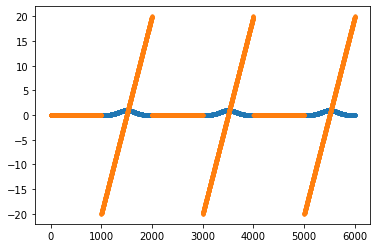

In [94]:
#Extract pulse samples for global channel
global_amp = []
global_det = []
for x in seq._schedule['global']:
    obj = x.type
    if type(obj) == Pulse:
        for t in range(obj.duration): 
            global_amp.append(obj.amplitude.samples[t])
            global_det.append(obj.detuning.samples[t])
    elif obj == 'delay':
        for t in range(x.tf - x.ti): 
            global_amp.append(0)
            global_det.append(0)

plt.plot(range(len(global_amp)),global_amp,'.')
plt.plot(range(len(global_det)),global_det,'.')

# Create callabe coeffs:

def global_amp_coeff(t,args):
    return global_amp[t]

def global_det_coeff(t,args):
    return global_det[t]

In [95]:
total_duration = max([seq._last(ch).tf for ch in seq._schedule])
times = np.arange(total_duration,dtype=np.double)

local_samples = {}
for i in range(L):
    local_samples[f'q{i}'] = {'amp':np.zeros(total_duration), 'det':np.zeros(total_duration)} 

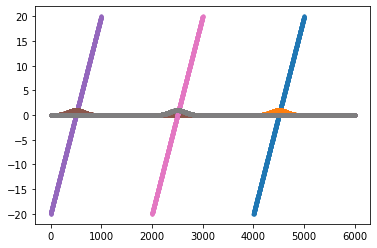

In [96]:
# Extract Pulse samples for local channel
for x in local_samples:
    for y in seq._schedule['local']:
        if type(y.type) == Pulse and x in y.targets:
            local_samples[x]['amp'][y.ti:y.tf] = y.type.amplitude.samples
            local_samples[x]['det'][y.ti:y.tf] = y.type.detuning.samples

for x in local_samples:
    plt.plot(times,local_samples[x]['det'],'.')
    plt.plot(times,local_samples[x]['amp'],'.')
    
# Define callable coefficient
def amp_coeff(t,args):
    """
    args : contains the qubit id
    """
    return local_samples[args['qubit_id']]['amp'][t]

def det_coeff(t,args):
    """
    args : contains the qubit id
    """
    return local_samples[args['qubit_id']]['det'][t]



Now that we have the samples as arrays, we construct the Hamiltonian objects using 

In [97]:
# Rotations (Using Rotating Wave Approximation):
def ryd_rotate(amplitude, detuning, phase):
    return 0.5*(amplitude*np.cos(phase)*sigma_gr - amplitude*np.sin(phase)*rydY + detuning*rydZ)

def exc_rotate(amplitude, detuning, phase):
    return 0.5*(amplitude*np.cos(phase)*sigma_ge - amplitude*np.sin(phase)*excY + detuning*excZ)

In [98]:
#Components for the Hamiltonian:

#Van der Waals Interaction Terms
VdW = 0
for i in range(1,L-1):
    VdW += two_body_operator(f'q{i}',f'q{i+1}', sigma_rr)

#Add VdW boundary terms
VdW += local_operator('q0', sigma_rr) + local_operator(f'q{L-1}', sigma_rr)

#Rydberg(Global) terms
global_X = 0
global_N = 0
for i in range(L):
    global_X += local_operator(f'q{i}',sigma_gr) #global rotation in the Ground-Rydberg basis
    global_N += local_operator(f'q{i}',sigma_rr)

In [99]:
#Build Hamiltonian
    
# Build Hamiltonian as QobjEvo, using the register's coordinates
H = 0
coords = np.array(reg1._coords)[:,0]

for i in range(len(coords)-1):
    R = np.abs(coords[i]-coords[i+1])
    H += qutip.QobjEvo( [ (1/R**6)*VdW] )

    
# Add Global X and N terms with coefficients taken from 'global' channel
H += qutip.QobjEvo( [global_N, np.array(global_det)] , tlist=times  )
H += qutip.QobjEvo( [global_X, np.array(global_amp)] , tlist=times  )

# Add Local terms taken from 'local' channel 
for i in range(L):
    amplitude = local_samples[f"q{i}"]['amp']
    detuning = local_samples[f"q{i}"]['det']
    H+=qutip.QobjEvo([local_operator(f'q{i}',exc_rotate(1,0,0)), amplitude], tlist=times)
    H+=qutip.QobjEvo([local_operator(f'q{i}',exc_rotate(0,1,0)), detuning], tlist=times)


We put our functions to work on by evolving the hamiltonian

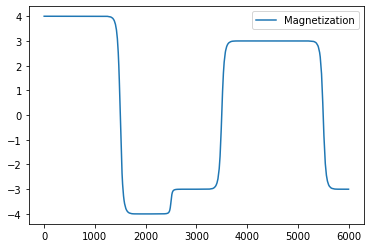

In [102]:
#Evolution using Qutip
initial = qutip.tensor([qutip.basis(3,0) for _ in range(L)])
data = []

# Add magnetization (in Rydberg basis) as observable
observable = 0
for i in range(L):
    observable += local_operator(f'q{i}',rydZ)

result = qutip.sesolve(H, initial, times, [observable]) # Without observables, we get the output state
data = result.expect[0]

plt.plot(times,data,label=f"Magnetization")
plt.legend()

